# Time Series Forecasting - Temperature

In this notebook we will create a model to forecast temperature and comment it, data cleaning and handling were made in the ETL notebook.

The purpose here is to implement a simple neural network using LSTM, GRU and CNN(1d), learn how to use it and compare performance.

### Justifying Architecture Choices

---

**Recurrent Neural Networks**

Recurrent Neural Networks (RNN) are designed to work with sequential data. Sequential data(can be time-series) can be in form of text, audio, video etc.
RNN uses the previous information in the sequence to produce the current output. 

But RNN's face short-term memory problem. It is caused due to vanishing gradient problem. As RNN processes more steps it suffers from vanishing gradient more than other neural network architectures.

The main problem is that it’s too difficult for RNN to learn to preserve information over many timesteps. In vanilla RNN the hidden state is constently being rewritten. For this problem there are two specialized versions of RNN:
- Long short-term memory (LSTM)
- Gated Recurrent Units (GRU)

The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.
 

**Long short-term memory (LSTM)**

- LSTM is a RNN architecture used in the field of deep learning. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).

- LSTM networks are well-suited to classifying, processing and making predictions based on time series data.

- LSTM was proposed by Sepp Hochreiter and Jürgen Schmidhuber. Some reference articles can be found at this link related to Recurrent Neural Networks: https://people.idsia.ch//~juergen/rnn.html


**Gated Recurrent Units (GRU)**

- The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM.
- The workflow of GRU is same as RNN but the difference is in the operations inside the GRU unit.
- Introduced in 2014 by Kyunghyun Cho et al, GRU are a gating mechanism in recurrent neural networks. Link: [Kyunghyun Cho et al](https://arxiv.org/abs/1406.1078) (2014)



LSTM has three gates on the other hand GRU has only two gates. In LSTM they are the Input gate, Forget gate, and Output gate. Whereas in GRU we have a Reset gate and Update gate.

**Convolutional Neural Network (CNN)**

- In deep learning, a convolutional neural network (CNN) is a class of artificial neural networks, usually associated with Image-related tasks. But it is possible to use for 1-dimensional outputs and be used in time series.

- CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks but this makes them prone to overfitting data. But since this is a lighter structure, it costs less to process and takes less time to train. Everything will depend on the application, available resources and performance, so it must be seen on a case-by-case basis.

In this case, it will be tested for learning purposes.

In [ ]:
!pip install -U scikit-learn

In [ ]:
import zipfile
import urllib

import os
import pandas as pd
import numpy as np

from scipy.stats import kurtosis
from statistics import mean, mode, median
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Setting Seaborn Theme
sns.set_theme(style="whitegrid", font_scale=1.4)

plt.rcParams["figure.figsize"] = (15,9)

In [ ]:
def train_model_LSTM(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1)):

    model = Sequential()
    model.add(InputLayer(input_layer))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp1 = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp1])

    return model

def train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1), model_type=1):
    model = Sequential()
    model.add(InputLayer(input_layer))
    if model_type==1:
        model.add(Conv1D(64, kernel_size=2))
    elif model_type==2:
        model.add(Conv1D(64, kernel_size=2,activation='relu'))  
    model.add(Flatten())
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))


    cp = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

    return model

def train_model_GRU(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1)):
    model = Sequential()
    model.add(InputLayer(input_layer))
    model.add(GRU(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp3 = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp3])

    return model

In [ ]:
def show_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name='LSTM'):
    print("_"*100)
    print(f"{model_name} Model".center(100, ' '))
    
    

    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - TRAIN DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_train,train_predictions)*100,2)}%')
    print('\n')
    print(train_results)
    train_results[:100].plot()
    plt.show()
    
    val_predictions = model.predict(X_val).flatten()
    val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - VALIDATION DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_val,val_predictions)*100,2)}%')
    print('\n')
    print(val_results);
    val_results[:100].plot()
    plt.show()
    
    test_predictions = model.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - TEST DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_test,test_predictions)*100,2)}%')
    print('\n')
    print(test_results)
    test_results[:100].plot()
    plt.show()

Here we will load preprocessed data ( cleaned and missing values handled)

In [ ]:
# Reading cleaned dataframe
df = pd.read_csv('brasilia_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime',inplace=True,drop=True)
print(f"DataFrame Shape: {df.shape}")

# Getting a dataframe with only temperature
temperature_df = df['Temperature']

DataFrame Shape: (87672, 2)


First we will visualize data.

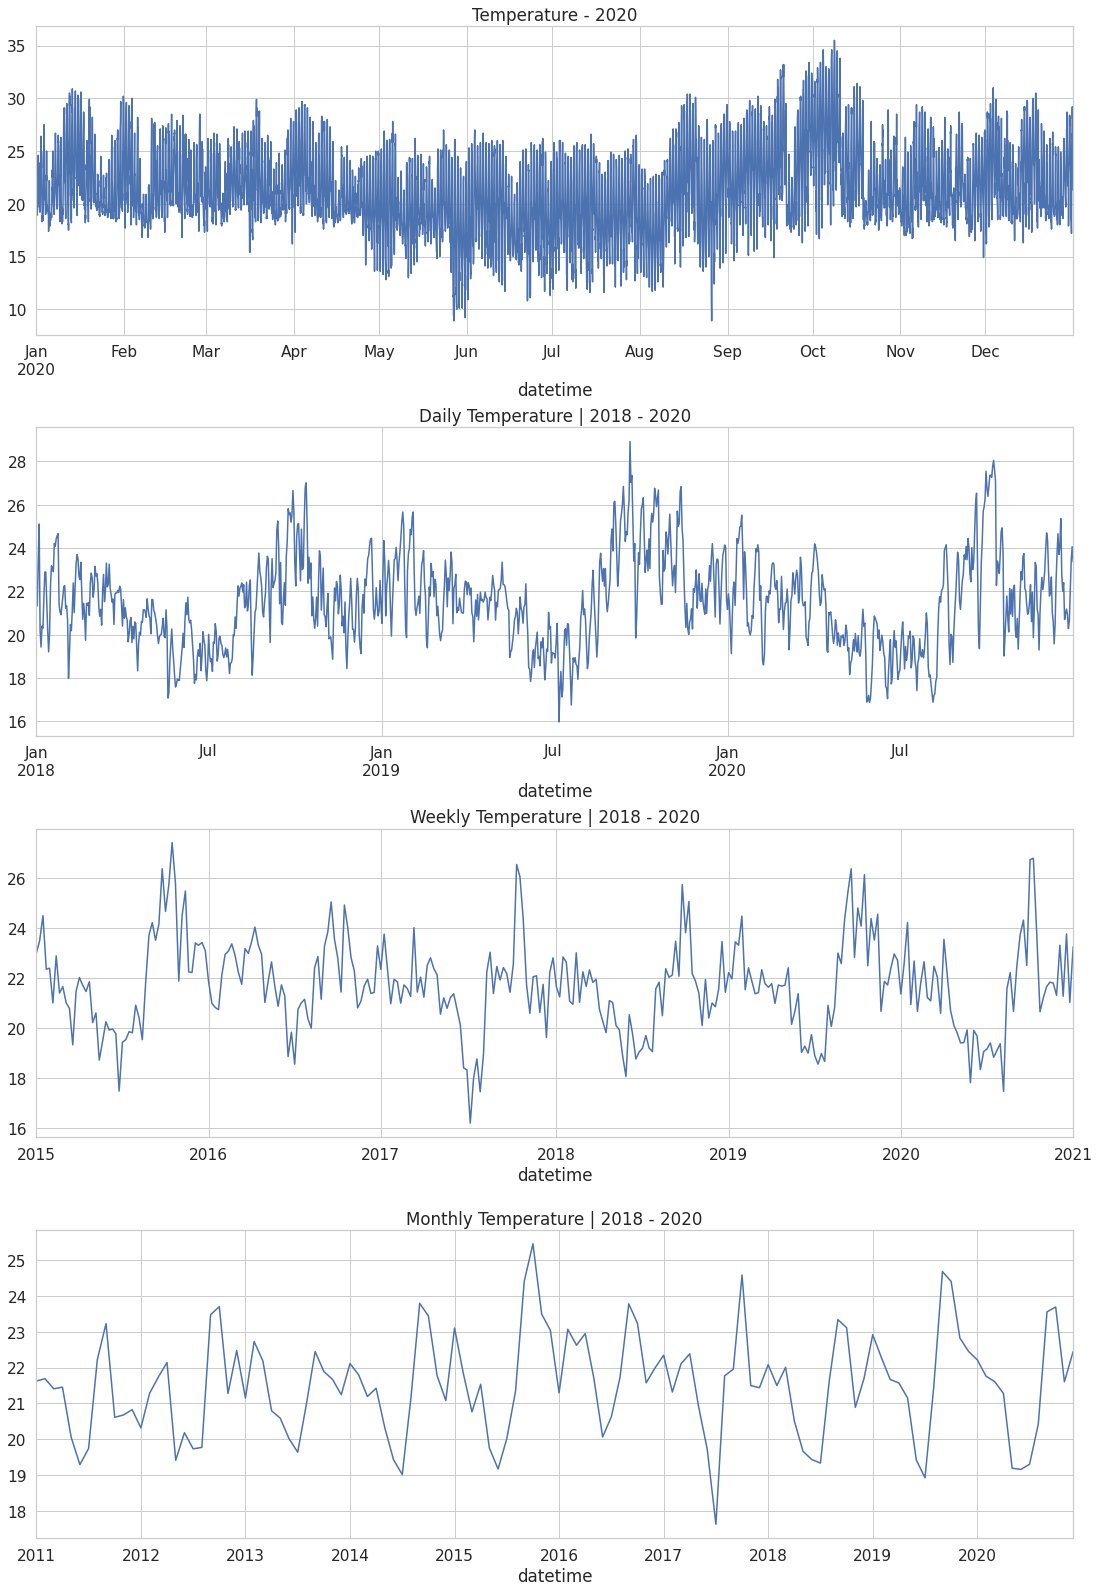

In [ ]:
plt.rcParams["figure.figsize"] = (18,15)
fig1, axs = plt.subplots(nrows=4, ncols=1)

axs[0] = temperature_df['2020':].plot(ax = axs[0],title='Temperature - 2020')
axs[1] = temperature_df['2018':].resample('D').mean().plot(ax = axs[1], title='Daily Temperature | 2018 - 2020')
axs[2] = temperature_df['2015':].resample('W').mean().plot(ax = axs[2], title='Weekly Temperature | 2018 - 2020')
axs[3] = temperature_df['2011':].resample('M').mean().plot(ax = axs[3], title='Monthly Temperature | 2018 - 2020')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.1, 
                    hspace=0.3)

plt.show()

Here we can see that temperature have some seasonality, so we can take advantage of this pattern at some point in this notebook.

Before starting with the models and predictions, let's check data distribution.

Skewness: 0.48
Kurtosis: -0.22


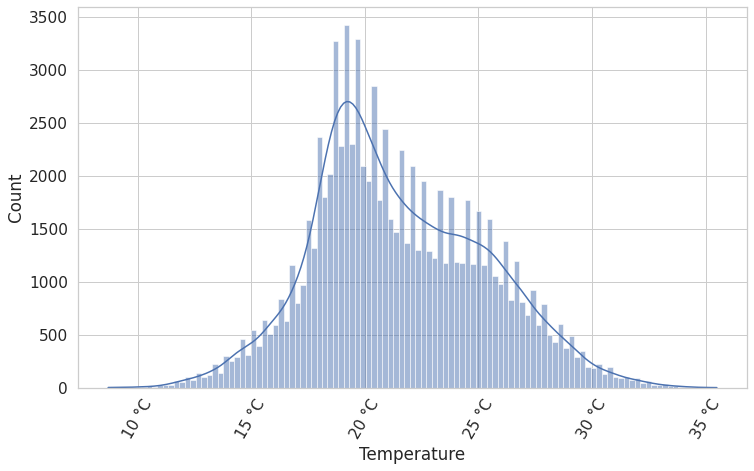

In [ ]:
# Calculating coefficient of skewness ( Pearson's second coefficient of skewness )
skewness = (3 * (temperature_df.mean() - temperature_df.median())) / temperature_df.std()

print(f"Skewness: {round(skewness, 2)}")
print(f'Kurtosis: {round(kurtosis(temperature_df), 2)}')

plt.rcParams["figure.figsize"] = (12,7)
ax = sns.histplot(data=temperature_df, kde=True)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} °C'))
plt.xticks(rotation=60)
plt.show()

Distribution ( skewness and kurtosis) looks ok, at this point we are ready to start with the models.

## First Model - Temperature and Sliding Window.

---

We were using only 2018 to 2020 data but we can see some sort of seasonality , which is good to use prophet, but lets see how it will behave with LSTM. Initially, without considering time itself and periodicity.

In this LSTM/GRU/CNN it will be used sliding windows as input, default will be using the last 5 hours to predict the next hour.

In [ ]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

def train_test_val_split(df, window_size=5):
    X, y = df_to_X_y(df, window_size)

    total_len = len(X)
    test_val_len = int(total_len * 0.10)
    train_len = total_len - (2*test_val_len)

    X_train, y_train = X[:train_len], y[:train_len]
    X_val, y_val = X[train_len:train_len + test_val_len], y[train_len:train_len + test_val_len]
    X_test, y_test = X[train_len + test_val_len:], y[train_len + test_val_len:]

    print("_"*40)
    print("    OUTPUT SHAPE\n")
    print(f" X train: {X_train.shape}\n y train: {y_train.shape}\n\n X val: {X_val.shape}\n y val: {y_val.shape}\n\n X test: {X_test.shape}\n y test:{y_test.shape}")
    print("_"*40)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split(temperature_df, 5)

________________________________________
    OUTPUT SHAPE

 X train: (70135, 5, 1)
 y train: (70135,)

 X val: (8766, 5, 1)
 y val: (8766,)

 X test: (8766, 5, 1)
 y test:(8766,)
________________________________________


### Model - LSTM
---

In [ ]:
%%time
model_LSTM = train_model_LSTM(X_train, y_train, X_val, y_val, 'model_LSTM', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 14s 5ms/step - loss: 96.7723 - root_mean_squared_error: 9.8373 - mean_absolute_percentage_error: 33.7823 - val_loss: 15.7986 - val_root_mean_squared_error: 3.9747 - val_mean_absolute_percentage_error: 14.5665


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 2/10
2192/2192 [==============================] - 11s 5ms/step - loss: 5.9060 - root_mean_squared_error: 2.4302 - mean_absolute_percentage_error: 8.3479 - val_loss: 2.2830 - val_root_mean_squared_error: 1.5109 - val_mean_absolute_percentage_error: 5.0241


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 3/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.4348 - root_mean_squared_error: 1.1978 - mean_absolute_percentage_error: 4.0354 - val_loss: 1.4735 - val_root_mean_squared_error: 1.2139 - val_mean_absolute_percentage_error: 4.0025


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 4/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.2130 - root_mean_squared_error: 1.1014 - mean_absolute_percentage_error: 3.6834 - val_loss: 1.3923 - val_root_mean_squared_error: 1.1800 - val_mean_absolute_percentage_error: 3.8964


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 5/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1758 - root_mean_squared_error: 1.0843 - mean_absolute_percentage_error: 3.6119 - val_loss: 1.3880 - val_root_mean_squared_error: 1.1781 - val_mean_absolute_percentage_error: 3.8516


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 6/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1595 - root_mean_squared_error: 1.0768 - mean_absolute_percentage_error: 3.5765 - val_loss: 1.3441 - val_root_mean_squared_error: 1.1593 - val_mean_absolute_percentage_error: 3.7102


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 7/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1497 - root_mean_squared_error: 1.0723 - mean_absolute_percentage_error: 3.5503 - val_loss: 1.3246 - val_root_mean_squared_error: 1.1509 - val_mean_absolute_percentage_error: 3.7124


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 8/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1424 - root_mean_squared_error: 1.0688 - mean_absolute_percentage_error: 3.5398 - val_loss: 1.3299 - val_root_mean_squared_error: 1.1532 - val_mean_absolute_percentage_error: 3.6830
Epoch 9/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1374 - root_mean_squared_error: 1.0665 - mean_absolute_percentage_error: 3.5205 - val_loss: 1.3115 - val_root_mean_squared_error: 1.1452 - val_mean_absolute_percentage_error: 3.7289


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 10/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1355 - root_mean_squared_error: 1.0656 - mean_absolute_percentage_error: 3.5169 - val_loss: 1.3363 - val_root_mean_squared_error: 1.1560 - val_mean_absolute_percentage_error: 3.6893
CPU times: user 3min 25s, sys: 8.34 s, total: 3min 33s
Wall time: 3min 24s


In [ ]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                      LSTM Model - TRAIN DATA                                       


MAPE: 3.47%


       Train Predictions  Actuals
0              17.468758     18.2
1              18.177336     17.8
2              17.758892     18.0
3              18.160793     17.9
4              18.031452     17.9
...                  ...      ...
70130          18.311632     18.2
70131          18.344086     18.4
70132          18.639799     18.0
70133          18.059216     18.7
70134          18.971611     19.0

[70135 rows x 2 columns]


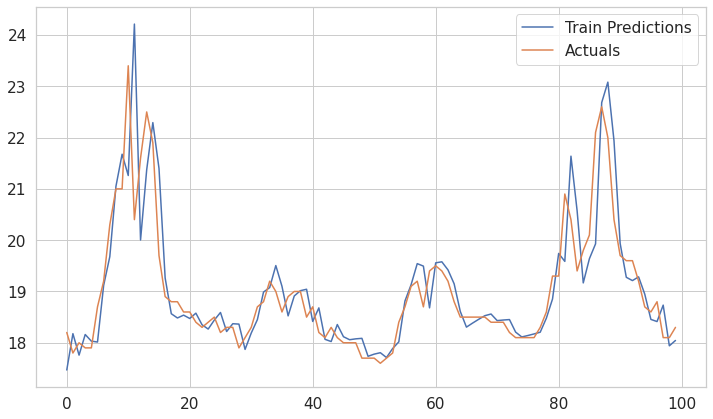




____________________________________________________________________________________________________
                                    LSTM Model - VALIDATION DATA                                    


MAPE: 3.69%


      Val Predictions  Actuals
0           19.294687     19.6
1           20.023111     22.2
2           23.322992     24.2
3           25.242865     24.8
4           25.522593     23.4
...               ...      ...
8761        23.239630     24.0
8762        24.833309     22.8
8763        22.824095     21.6
8764        21.097775     24.6
8765        24.549192     24.5

[8766 rows x 2 columns]


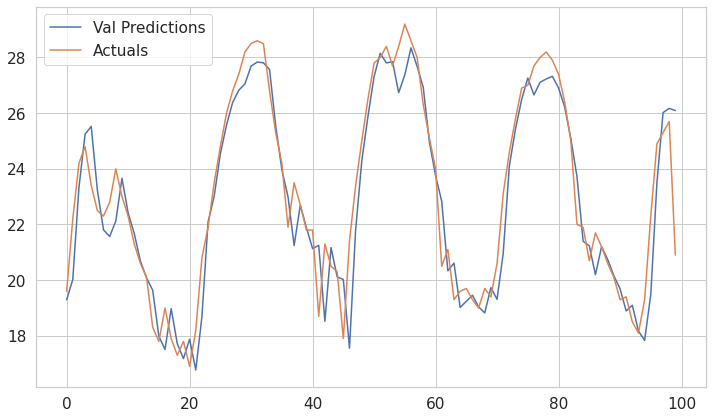




____________________________________________________________________________________________________
                                       LSTM Model - TEST DATA                                       


MAPE: 3.63%


      Test Predictions  Actuals
0            23.963978     20.0
1            19.799097     22.3
2            21.921350     23.9
3            23.471945     23.9
4            23.501474     21.7
...                ...      ...
8761         27.132717     28.1
8762         26.899828     23.6
8763         22.775808     23.6
8764         22.563532     22.3
8765         21.484388     21.3

[8766 rows x 2 columns]


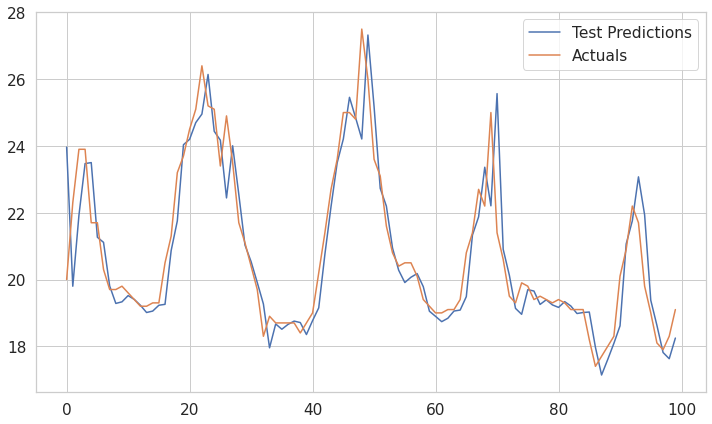

In [ ]:
plt.rcParams["figure.figsize"] = (12,7)
show_model(model_LSTM, X_train, y_train, X_val, y_val, X_test, y_test)

### Model - GRU
---

In [ ]:
%%time
model_GRU = train_model_GRU(X_train, y_train, X_val, y_val, 'model_GRU', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 14s 6ms/step - loss: 69.6058 - root_mean_squared_error: 8.3430 - mean_absolute_percentage_error: 25.2101 - val_loss: 3.3761 - val_root_mean_squared_error: 1.8374 - val_mean_absolute_percentage_error: 5.7240


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 2/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.6324 - root_mean_squared_error: 1.2777 - mean_absolute_percentage_error: 4.1991 - val_loss: 1.5636 - val_root_mean_squared_error: 1.2505 - val_mean_absolute_percentage_error: 4.0529


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 3/10
2192/2192 [==============================] - 12s 6ms/step - loss: 1.2430 - root_mean_squared_error: 1.1149 - mean_absolute_percentage_error: 3.7074 - val_loss: 1.4160 - val_root_mean_squared_error: 1.1900 - val_mean_absolute_percentage_error: 3.8296


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 4/10
2192/2192 [==============================] - 12s 6ms/step - loss: 1.1874 - root_mean_squared_error: 1.0897 - mean_absolute_percentage_error: 3.6192 - val_loss: 1.3780 - val_root_mean_squared_error: 1.1739 - val_mean_absolute_percentage_error: 3.8177


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 5/10
2192/2192 [==============================] - 12s 6ms/step - loss: 1.1655 - root_mean_squared_error: 1.0796 - mean_absolute_percentage_error: 3.5771 - val_loss: 1.3370 - val_root_mean_squared_error: 1.1563 - val_mean_absolute_percentage_error: 3.7571


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 6/10
2192/2192 [==============================] - 12s 6ms/step - loss: 1.1533 - root_mean_squared_error: 1.0739 - mean_absolute_percentage_error: 3.5520 - val_loss: 1.3226 - val_root_mean_squared_error: 1.1500 - val_mean_absolute_percentage_error: 3.7543


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 7/10
2192/2192 [==============================] - 12s 6ms/step - loss: 1.1447 - root_mean_squared_error: 1.0699 - mean_absolute_percentage_error: 3.5349 - val_loss: 1.3233 - val_root_mean_squared_error: 1.1504 - val_mean_absolute_percentage_error: 3.7268
Epoch 8/10
2192/2192 [==============================] - 12s 6ms/step - loss: 1.1385 - root_mean_squared_error: 1.0670 - mean_absolute_percentage_error: 3.5228 - val_loss: 1.3448 - val_root_mean_squared_error: 1.1597 - val_mean_absolute_percentage_error: 3.7727
Epoch 9/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1349 - root_mean_squared_error: 1.0653 - mean_absolute_percentage_error: 3.5146 - val_loss: 1.3291 - val_root_mean_squared_error: 1.1529 - val_mean_absolute_percentage_error: 3.7280
Epoch 10/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1331 - root_mean_squared_error: 1.0645 - mean_absolute_percentage_error: 3.5080 - val_loss: 1.3367 - val_root_mean_squared_error: 1.1561 

In [ ]:
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


____________________________________________________________________________________________________
                                             GRU Model                                              



____________________________________________________________________________________________________
                                       GRU Model - TRAIN DATA                                       


MAPE: 3.52%


       Train Predictions  Actuals
0              17.515966     18.2
1              18.310381     17.8
2              17.836924     18.0
3              18.174047     17.9
4              18.033918     17.9
...                  ...      ...
70130          18.403284     18.2
70131          18.394997     18.4
70132          18.655657     18.0
70133          18.044064     18.7
70134          19.058668     19.0

[70135 rows x 2 columns]


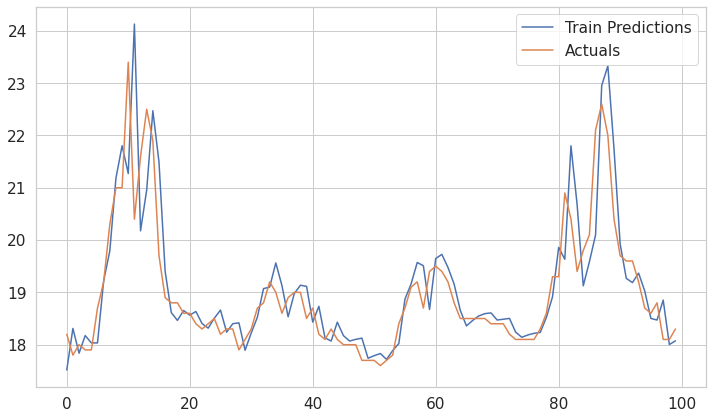




____________________________________________________________________________________________________
                                    GRU Model - VALIDATION DATA                                     


MAPE: 3.75%


      Val Predictions  Actuals
0           19.405149     19.6
1           20.138445     22.2
2           23.430843     24.2
3           25.240879     24.8
4           25.535994     23.4
...               ...      ...
8761        23.396894     24.0
8762        24.894688     22.8
8763        22.640068     21.6
8764        20.890446     24.6
8765        24.517015     24.5

[8766 rows x 2 columns]


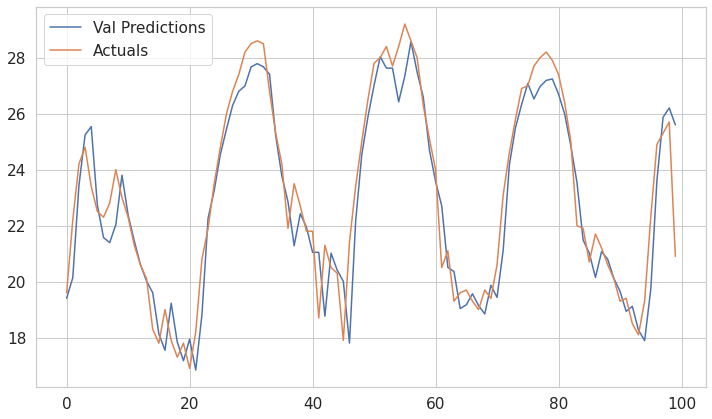




____________________________________________________________________________________________________
                                       GRU Model - TEST DATA                                        


MAPE: 3.7%


      Test Predictions  Actuals
0            24.563580     20.0
1            20.168030     22.3
2            21.386120     23.9
3            24.060631     23.9
4            23.888086     21.7
...                ...      ...
8761         26.796419     28.1
8762         26.863398     23.6
8763         22.877766     23.6
8764         22.288731     22.3
8765         21.437042     21.3

[8766 rows x 2 columns]


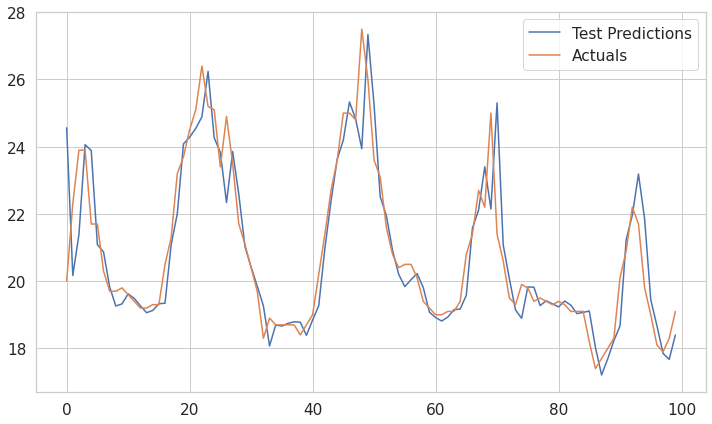

In [ ]:
show_model(model_GRU, X_train, y_train, X_val, y_val, X_test, y_test, model_name='GRU')

### Model - Conv 1d
---

In [ ]:
%%time
model_conv1d = train_model_conv1d(X_train, y_train, X_val, y_val, 'model_conv1d', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 5s 2ms/step - loss: 33.5716 - root_mean_squared_error: 5.7941 - mean_absolute_percentage_error: 16.3743 - val_loss: 5.7445 - val_root_mean_squared_error: 2.3968 - val_mean_absolute_percentage_error: 8.7850
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 2/10
2192/2192 [==============================] - 4s 2ms/step - loss: 3.6970 - root_mean_squared_error: 1.9227 - mean_absolute_percentage_error: 6.8969 - val_loss: 2.1085 - val_root_mean_squared_error: 1.4521 - val_mean_absolute_percentage_error: 4.8666
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 3/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.5902 - root_mean_squared_error: 1.2610 - mean_absolute_percentage_error: 4.1738 - val_loss: 1.6273 - val_root_mean_squared_error: 1.2756 - val_mean_absolute_percentage_error: 4.1362
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 4/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.3593 - root_mean_squared_error: 1.1659 - mean_absolute_percentage_error: 3.8338 - val_loss: 1.4895 - val_root_mean_squared_error: 1.2205 - val_mean_absolute_percentage_error: 3.9411
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 5/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2886 - root_mean_squared_error: 1.1351 - mean_absolute_percentage_error: 3.7392 - val_loss: 1.5414 - val_root_mean_squared_error: 1.2415 - val_mean_absolute_percentage_error: 4.0069
Epoch 6/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2681 - root_mean_squared_error: 1.1261 - mean_absolute_percentage_error: 3.7245 - val_loss: 1.5763 - val_root_mean_squared_error: 1.2555 - val_mean_absolute_percentage_error: 4.0862
Epoch 7/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2604 - root_mean_squared_error: 1.1227 - mean_absolute_percentage_error: 3.7293 - val_loss: 1.4472 - val_root_mean_squared_error: 1.2030 - val_mean_absolute_percentage_error: 3.8808
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 8/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2521 - root_mean_squared_error: 1.1190 - mean_absolute_percentage_error: 3.7331 - val_loss: 1.4664 - val_root_mean_squared_error: 1.2110 - val_mean_absolute_percentage_error: 3.9181
Epoch 9/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2495 - root_mean_squared_error: 1.1178 - mean_absolute_percentage_error: 3.7346 - val_loss: 1.4363 - val_root_mean_squared_error: 1.1985 - val_mean_absolute_percentage_error: 3.9647
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 10/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2488 - root_mean_squared_error: 1.1175 - mean_absolute_percentage_error: 3.7449 - val_loss: 1.4398 - val_root_mean_squared_error: 1.1999 - val_mean_absolute_percentage_error: 3.9911
CPU times: user 51.2 s, sys: 4.44 s, total: 55.6 s
Wall time: 1min 22s


In [ ]:
model_conv1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             192       
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


____________________________________________________________________________________________________
                                           Conv 1d Model                                            



____________________________________________________________________________________________________
                                     Conv 1d Model - TRAIN DATA                                     


MAPE: 3.88%


       Train Predictions  Actuals
0              17.981667     18.2
1              18.653620     17.8
2              18.247631     18.0
3              18.589937     17.9
4              18.489037     17.9
...                  ...      ...
70130          18.759197     18.2
70131          18.773865     18.4
70132          19.032839     18.0
70133          18.535707     18.7
70134          19.342390     19.0

[70135 rows x 2 columns]


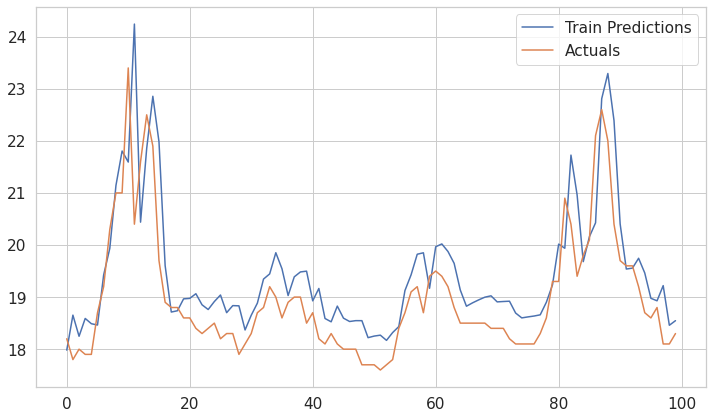




____________________________________________________________________________________________________
                                  Conv 1d Model - VALIDATION DATA                                   


MAPE: 3.99%


      Val Predictions  Actuals
0           19.652779     19.6
1           20.293905     22.2
2           23.256397     24.2
3           25.283478     24.8
4           25.625910     23.4
...               ...      ...
8761        23.251068     24.0
8762        24.898144     22.8
8763        23.197433     21.6
8764        21.610502     24.6
8765        25.007072     24.5

[8766 rows x 2 columns]


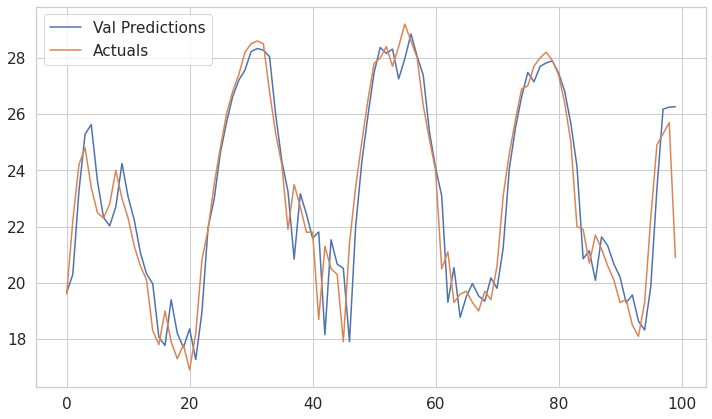




____________________________________________________________________________________________________
                                     Conv 1d Model - TEST DATA                                      


MAPE: 4.02%


      Test Predictions  Actuals
0            24.669157     20.0
1            19.432936     22.3
2            22.382730     23.9
3            24.084179     23.9
4            24.093348     21.7
...                ...      ...
8761         27.650787     28.1
8762         27.472523     23.6
8763         22.241047     23.6
8764         22.664953     22.3
8765         21.412197     21.3

[8766 rows x 2 columns]


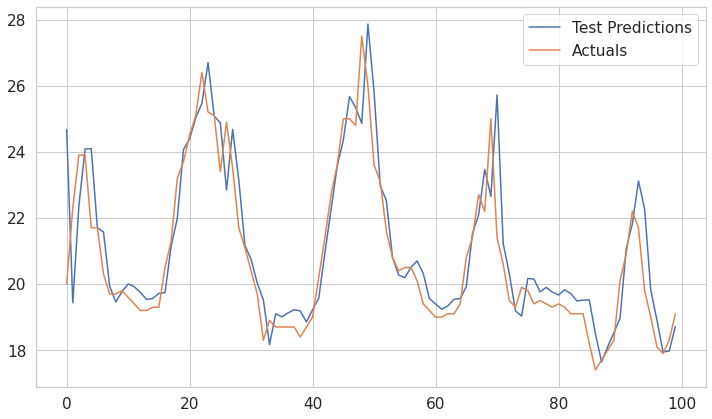

In [ ]:
show_model(model_conv1d, X_train, y_train, X_val, y_val, X_test, y_test, model_name='Conv 1d')

### Notes about first models

We can note that the three models had similar performance, but as we can see below there is a significant difference in the number of parameters. In practice, this means that the Conv-1d model for example benefits from being lighter but with a performance similar to GRU and LSTM

In [ ]:
print("LSTM\n")
model_LSTM.summary()

LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("GRU\n")
model_GRU.summary()

GRU

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Conv1d\n")
model_conv1d.summary()

Conv1d

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             192       
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


## Second Model - Temperature, Time and Sliding Window

---

Some data is inherently cyclical. Time is a rich example of this: 
- Minutes; 
- Hours;
- Seconds;
- Day of the Week;
- Week of the Month;
- Month; 
- Season;

and so on all follow cycles.

---

We have already noted at the beginning of this notebook that our data have seasonality, meaning that this data is cyclical.

The thought behind it is not really an out-of-the-box idea, because usually during the day is hotter than in the middle of the night and during winter we have lower temperatures than in the summer. All of this can be fit in a 24 hours a day cycle and in a 365.2425 days a year cycle.

So this second model will try to use this information.

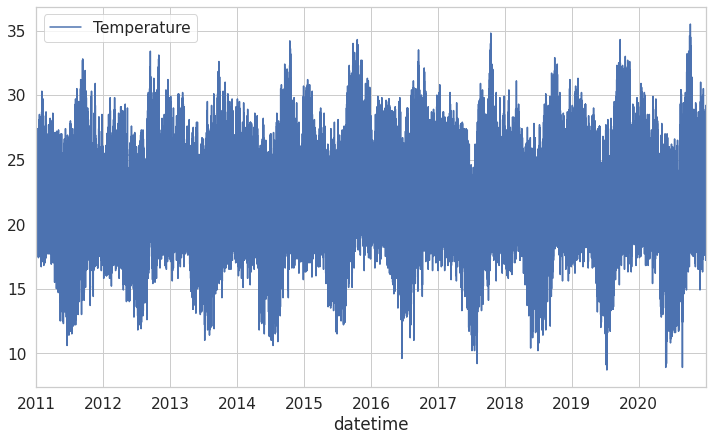

In [ ]:
temp_df = pd.DataFrame({'Temperature':temperature_df})
temp_df.plot();

It is a noisy plot ( No need to plot all grouped plots again), but we can notice a cyclical pattern.

So the first step is to transform DateTime data into useful information.

When we are dealing with time-series data, it is also common that our dataframe's index has a DateTime format (YYYY-MM-DD HH:MM:SS) and it is true in our case too, because of that we will not extract much information from it, except the ascending order of data points. But there might be some hidden patterns in your dataset that will not be revealed by the regular features, so first we will need to transform them into timestamps

A ***timestamp*** basically represents a single instant, a specific point on the timeline, and its value corresponds to a certain amount of time elapsed from an initial instant. In our case, it is represented in seconds and will require some transformations to get it in a useful format.

In [ ]:
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
datetime,,
2011-01-01 00:00:00,19.2,1.293840e+09
2011-01-01 01:00:00,19.3,1.293844e+09
2011-01-01 02:00:00,19.1,1.293847e+09
2011-01-01 03:00:00,18.1,1.293851e+09
2011-01-01 04:00:00,17.7,1.293854e+09
...,...,...
2020-12-31 19:00:00,28.1,1.609441e+09
2020-12-31 20:00:00,23.6,1.609445e+09
2020-12-31 21:00:00,23.6,1.609448e+09


Now to extract information from the timestamps we need to get cyclical behavior from this, since we know that a day have 24 hours and a year have 365.2425 days, we can make an abstraction using Sin and Cosine in order to get cyclical behavior.

For example:  Cosine varies between -1 and 1 according to a 0–2π cycle.

<p align="center"><img src="https://www.math.hkust.edu.hk/~machiang/1013/Notes/cosine_2.gif" height="300px"></p>

It looks all set and done, but there is a catch:

As we can see in the gif above, at some point we will have diferent times with the same cosine, which will give our models the wrong idea that this 2 different hours are the same.

So we probably need to add another cyclical information in order to distinguish these two times with identical cosine values.

We could think of it as a two-axis coordinates system.

To solve this, we will use Sin and you can check it bellow:

<p align="center"><img src="https://www.math.hkust.edu.hk/~machiang/1013/Notes/sine_2.gif" height="300px"></p>

Combining Sin and Cosine we will have an unique coordinate for hours and year. Now we will transform our 'Seconds' using Sin and Cos.

In [ ]:
# Getting Seconds in a Day
day = 60*60*24

# Getting Seconds in a Year
year = 365.2425*day

# Creating features out of sin and cos
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
datetime,,,,,,
2011-01-01 00:00:00,19.2,1.293840e+09,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,1.293844e+09,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,1.293847e+09,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,1.293851e+09,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,1.293854e+09,8.660254e-01,0.500000,0.003856,0.999993


Drop **Seconds** column since it is continuous and it will not add any information to the model.

In [ ]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2011-01-01 00:00:00,19.2,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,8.660254e-01,0.500000,0.003856,0.999993


In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

def train_test_val_split2(df, window_size=6):
    X, y = df_to_X_y2(df, window_size)

    total_len = len(X)
    test_val_len = int(total_len * 0.10)
    train_len = total_len - (2*test_val_len)

    X_train, y_train = X[:train_len], y[:train_len]
    X_val, y_val = X[train_len:train_len + test_val_len], y[train_len:train_len + test_val_len]
    X_test, y_test = X[train_len + test_val_len:], y[train_len + test_val_len:]

    print("_"*40)
    print("    OUTPUT SHAPE\n")
    print(f" X train: {X_train.shape}\n y train: {y_train.shape}\n\n X val: {X_val.shape}\n y val: {y_val.shape}\n\n X test: {X_test.shape}\n y test:{y_test.shape}")
    print("_"*40)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X2_train, y2_train, X2_val, y2_val, X2_test, y2_test = train_test_val_split2(temp_df)

________________________________________
    OUTPUT SHAPE

 X train: (70134, 6, 5)
 y train: (70134,)

 X val: (8766, 6, 5)
 y val: (8766,)

 X test: (8766, 6, 5)
 y test:(8766,)
________________________________________


### Model - LSTM
---

In [ ]:
%%time
model_LSTM_cyclic = train_model_LSTM(X2_train, y2_train, X2_val, y2_val, 'model_LSTM_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5))

Epoch 1/10
2192/2192 [==============================] - 16s 6ms/step - loss: 229.3590 - root_mean_squared_error: 15.1446 - mean_absolute_percentage_error: 63.0011 - val_loss: 49.4068 - val_root_mean_squared_error: 7.0290 - val_mean_absolute_percentage_error: 25.2810


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 13s 6ms/step - loss: 17.4974 - root_mean_squared_error: 4.1830 - mean_absolute_percentage_error: 14.8232 - val_loss: 10.4202 - val_root_mean_squared_error: 3.2280 - val_mean_absolute_percentage_error: 10.9382


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 13s 6ms/step - loss: 2.8889 - root_mean_squared_error: 1.6997 - mean_absolute_percentage_error: 5.2325 - val_loss: 1.7243 - val_root_mean_squared_error: 1.3131 - val_mean_absolute_percentage_error: 4.1807


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.1013 - root_mean_squared_error: 1.0494 - mean_absolute_percentage_error: 3.4284 - val_loss: 1.1818 - val_root_mean_squared_error: 1.0871 - val_mean_absolute_percentage_error: 3.4899


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.9442 - root_mean_squared_error: 0.9717 - mean_absolute_percentage_error: 3.1791 - val_loss: 1.0868 - val_root_mean_squared_error: 1.0425 - val_mean_absolute_percentage_error: 3.3812


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.9105 - root_mean_squared_error: 0.9542 - mean_absolute_percentage_error: 3.1130 - val_loss: 1.0606 - val_root_mean_squared_error: 1.0299 - val_mean_absolute_percentage_error: 3.2470


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.8986 - root_mean_squared_error: 0.9479 - mean_absolute_percentage_error: 3.0903 - val_loss: 1.0441 - val_root_mean_squared_error: 1.0218 - val_mean_absolute_percentage_error: 3.2603


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.8905 - root_mean_squared_error: 0.9437 - mean_absolute_percentage_error: 3.0763 - val_loss: 1.0294 - val_root_mean_squared_error: 1.0146 - val_mean_absolute_percentage_error: 3.2349


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.8823 - root_mean_squared_error: 0.9393 - mean_absolute_percentage_error: 3.0562 - val_loss: 1.0186 - val_root_mean_squared_error: 1.0093 - val_mean_absolute_percentage_error: 3.2042


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 10/10
2192/2192 [==============================] - 12s 6ms/step - loss: 0.8751 - root_mean_squared_error: 0.9355 - mean_absolute_percentage_error: 3.0457 - val_loss: 1.0279 - val_root_mean_squared_error: 1.0139 - val_mean_absolute_percentage_error: 3.2611
CPU times: user 3min 58s, sys: 9.46 s, total: 4min 7s
Wall time: 3min 1s


____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                      LSTM Model - TRAIN DATA                                       


MAPE: 3.06%


       Train Predictions  Actuals
0              18.072765     17.8
1              17.761894     18.0
2              17.937597     17.9
3              18.141979     17.9
4              18.650139     18.7
...                  ...      ...
70129          18.039602     18.2
70130          18.109241     18.4
70131          18.560991     18.0
70132          18.742241     18.7
70133          19.903332     19.0

[70134 rows x 2 columns]


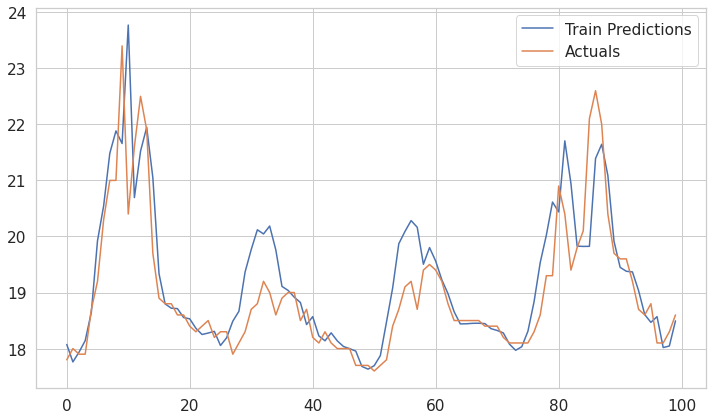




____________________________________________________________________________________________________
                                    LSTM Model - VALIDATION DATA                                    


MAPE: 3.26%


      Val Predictions  Actuals
0           20.363155     19.6
1           20.865093     22.2
2           23.120367     24.2
3           24.631792     24.8
4           24.863297     23.4
...               ...      ...
8761        23.443619     24.0
8762        24.666388     22.8
8763        23.297022     21.6
8764        22.025669     24.6
8765        24.650425     24.5

[8766 rows x 2 columns]


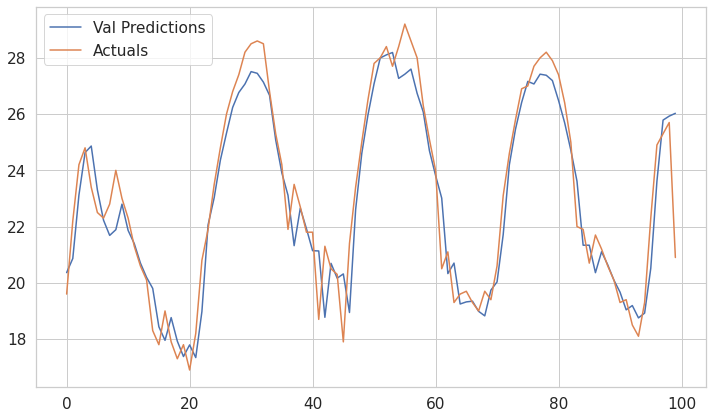




____________________________________________________________________________________________________
                                       LSTM Model - TEST DATA                                       


MAPE: 3.21%


      Test Predictions  Actuals
0            24.018734     20.0
1            19.899408     22.3
2            21.663149     23.9
3            22.846237     23.9
4            22.604303     21.7
...                ...      ...
8761         27.270260     28.1
8762         26.670750     23.6
8763         22.509800     23.6
8764         22.628847     22.3
8765         21.539955     21.3

[8766 rows x 2 columns]


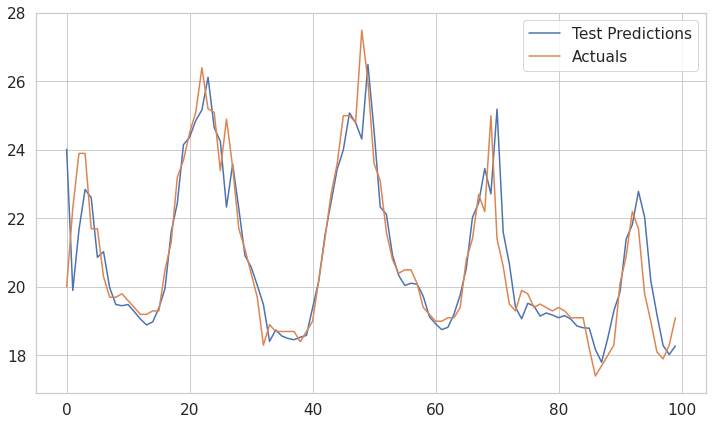

In [ ]:
show_model(model_LSTM_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='LSTM')

### Model - GRU
---

In [ ]:
%%time
model_GRU_cyclic = train_model_GRU(X2_train, y2_train, X2_val, y2_val, 'model_GRU_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5))

Epoch 1/10
2192/2192 [==============================] - 15s 6ms/step - loss: 80.6530 - root_mean_squared_error: 8.9807 - mean_absolute_percentage_error: 29.2974 - val_loss: 4.9668 - val_root_mean_squared_error: 2.2286 - val_mean_absolute_percentage_error: 6.4225


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.7636 - root_mean_squared_error: 1.3280 - mean_absolute_percentage_error: 4.0962 - val_loss: 1.4140 - val_root_mean_squared_error: 1.1891 - val_mean_absolute_percentage_error: 3.7685


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.0359 - root_mean_squared_error: 1.0178 - mean_absolute_percentage_error: 3.3271 - val_loss: 1.1517 - val_root_mean_squared_error: 1.0732 - val_mean_absolute_percentage_error: 3.4537


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.9593 - root_mean_squared_error: 0.9795 - mean_absolute_percentage_error: 3.2156 - val_loss: 1.0975 - val_root_mean_squared_error: 1.0476 - val_mean_absolute_percentage_error: 3.3868


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 14s 6ms/step - loss: 0.9346 - root_mean_squared_error: 0.9668 - mean_absolute_percentage_error: 3.1661 - val_loss: 1.0735 - val_root_mean_squared_error: 1.0361 - val_mean_absolute_percentage_error: 3.3298


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 16s 7ms/step - loss: 0.9191 - root_mean_squared_error: 0.9587 - mean_absolute_percentage_error: 3.1314 - val_loss: 1.0596 - val_root_mean_squared_error: 1.0294 - val_mean_absolute_percentage_error: 3.3017


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 14s 6ms/step - loss: 0.9125 - root_mean_squared_error: 0.9553 - mean_absolute_percentage_error: 3.1186 - val_loss: 1.0500 - val_root_mean_squared_error: 1.0247 - val_mean_absolute_percentage_error: 3.2728


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 14s 6ms/step - loss: 0.9059 - root_mean_squared_error: 0.9518 - mean_absolute_percentage_error: 3.1030 - val_loss: 1.0459 - val_root_mean_squared_error: 1.0227 - val_mean_absolute_percentage_error: 3.2395


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 14s 6ms/step - loss: 0.9021 - root_mean_squared_error: 0.9498 - mean_absolute_percentage_error: 3.0943 - val_loss: 1.0685 - val_root_mean_squared_error: 1.0337 - val_mean_absolute_percentage_error: 3.3279
Epoch 10/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.8963 - root_mean_squared_error: 0.9467 - mean_absolute_percentage_error: 3.0861 - val_loss: 1.0336 - val_root_mean_squared_error: 1.0167 - val_mean_absolute_percentage_error: 3.2293


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


CPU times: user 3min 58s, sys: 10.4 s, total: 4min 8s
Wall time: 3min 23s


____________________________________________________________________________________________________
                                             GRU Model                                              



____________________________________________________________________________________________________
                                       GRU Model - TRAIN DATA                                       


MAPE: 3.05%


       Train Predictions  Actuals
0              17.978113     17.8
1              17.724953     18.0
2              18.035629     17.9
3              18.210455     17.9
4              18.616001     18.7
...                  ...      ...
70129          18.017897     18.2
70130          18.183762     18.4
70131          18.670004     18.0
70132          18.633434     18.7
70133          19.940857     19.0

[70134 rows x 2 columns]


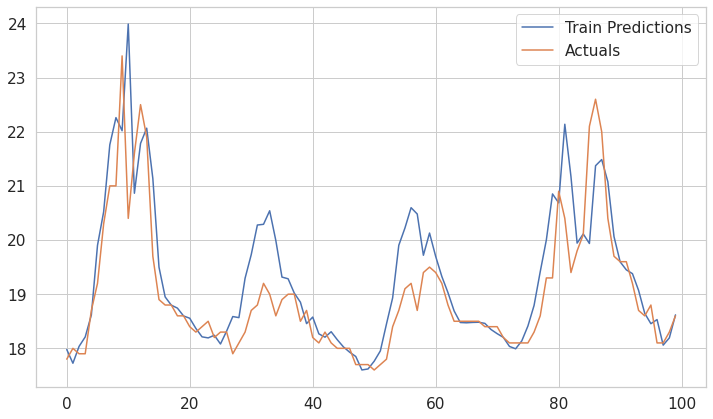




____________________________________________________________________________________________________
                                    GRU Model - VALIDATION DATA                                     


MAPE: 3.23%


      Val Predictions  Actuals
0           20.318434     19.6
1           21.072454     22.2
2           23.481930     24.2
3           24.998264     24.8
4           25.280605     23.4
...               ...      ...
8761        23.664917     24.0
8762        24.953953     22.8
8763        23.580853     21.6
8764        22.226234     24.6
8765        24.771036     24.5

[8766 rows x 2 columns]


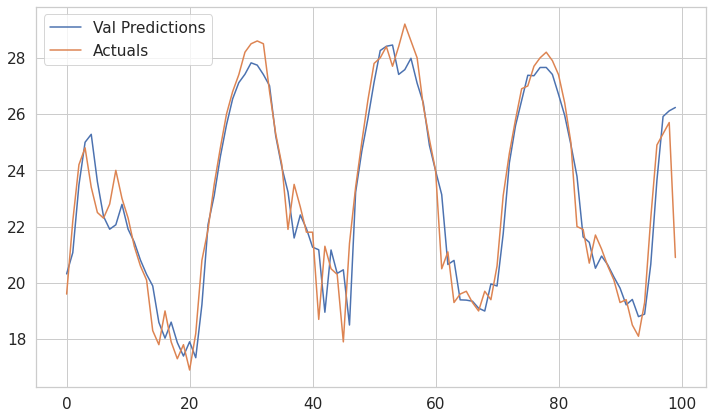




____________________________________________________________________________________________________
                                       GRU Model - TEST DATA                                        


MAPE: 3.2%


      Test Predictions  Actuals
0            24.284689     20.0
1            20.219751     22.3
2            21.954369     23.9
3            22.702305     23.9
4            22.520205     21.7
...                ...      ...
8761         27.299461     28.1
8762         26.936705     23.6
8763         22.679699     23.6
8764         22.804737     22.3
8765         21.662498     21.3

[8766 rows x 2 columns]


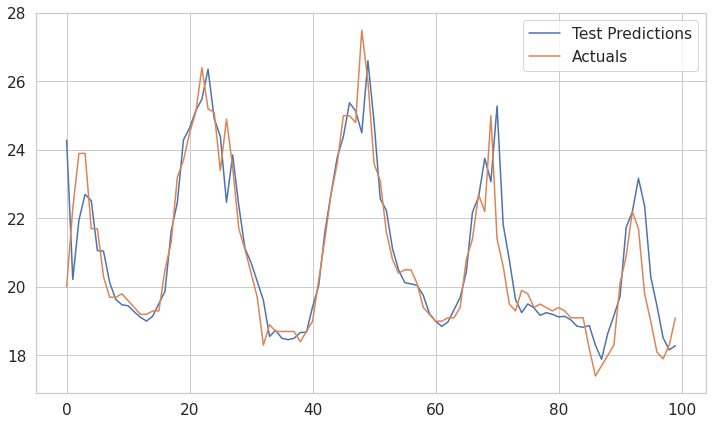

In [ ]:
show_model(model_GRU_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='GRU')

### Model - Conv1d
---

In [ ]:
%%time
model_conv1d_cyclic = train_model_conv1d(X2_train, y2_train, X2_val, y2_val, 'model_conv1d_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5),model_type=2)

Epoch 1/10
2192/2192 [==============================] - 5s 2ms/step - loss: 12.9965 - root_mean_squared_error: 3.6051 - mean_absolute_percentage_error: 9.8444 - val_loss: 2.2278 - val_root_mean_squared_error: 1.4926 - val_mean_absolute_percentage_error: 5.4554
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.7564 - root_mean_squared_error: 1.3253 - mean_absolute_percentage_error: 4.9501 - val_loss: 1.6593 - val_root_mean_squared_error: 1.2881 - val_mean_absolute_percentage_error: 4.6298
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2574 - root_mean_squared_error: 1.1213 - mean_absolute_percentage_error: 3.9834 - val_loss: 1.2410 - val_root_mean_squared_error: 1.1140 - val_mean_absolute_percentage_error: 3.7305
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.0283 - root_mean_squared_error: 1.0140 - mean_absolute_percentage_error: 3.4091 - val_loss: 1.1303 - val_root_mean_squared_error: 1.0632 - val_mean_absolute_percentage_error: 3.4375
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 4s 2ms/step - loss: 0.9707 - root_mean_squared_error: 0.9852 - mean_absolute_percentage_error: 3.2487 - val_loss: 1.1103 - val_root_mean_squared_error: 1.0537 - val_mean_absolute_percentage_error: 3.4115
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 4s 2ms/step - loss: 0.9542 - root_mean_squared_error: 0.9768 - mean_absolute_percentage_error: 3.2003 - val_loss: 1.0968 - val_root_mean_squared_error: 1.0473 - val_mean_absolute_percentage_error: 3.3713
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 4s 2ms/step - loss: 0.9452 - root_mean_squared_error: 0.9722 - mean_absolute_percentage_error: 3.1723 - val_loss: 1.0940 - val_root_mean_squared_error: 1.0460 - val_mean_absolute_percentage_error: 3.3682
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 4s 2ms/step - loss: 0.9416 - root_mean_squared_error: 0.9704 - mean_absolute_percentage_error: 3.1649 - val_loss: 1.0759 - val_root_mean_squared_error: 1.0373 - val_mean_absolute_percentage_error: 3.2934
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 4s 2ms/step - loss: 0.9398 - root_mean_squared_error: 0.9695 - mean_absolute_percentage_error: 3.1568 - val_loss: 1.0899 - val_root_mean_squared_error: 1.0440 - val_mean_absolute_percentage_error: 3.3059
Epoch 10/10
2192/2192 [==============================] - 4s 2ms/step - loss: 0.9385 - root_mean_squared_error: 0.9688 - mean_absolute_percentage_error: 3.1526 - val_loss: 1.0900 - val_root_mean_squared_error: 1.0440 - val_mean_absolute_percentage_error: 3.3522
CPU times: user 57.3 s, sys: 5.08 s, total: 1min 2s
Wall time: 50.3 s


____________________________________________________________________________________________________
                                            Conv1d Model                                            



____________________________________________________________________________________________________
                                     Conv1d Model - TRAIN DATA                                      


MAPE: 3.15%


       Train Predictions  Actuals
0              17.999605     17.8
1              17.645872     18.0
2              17.907167     17.9
3              18.041285     17.9
4              18.489038     18.7
...                  ...      ...
70129          17.950045     18.2
70130          18.024939     18.4
70131          18.492434     18.0
70132          18.559862     18.7
70133          19.698713     19.0

[70134 rows x 2 columns]


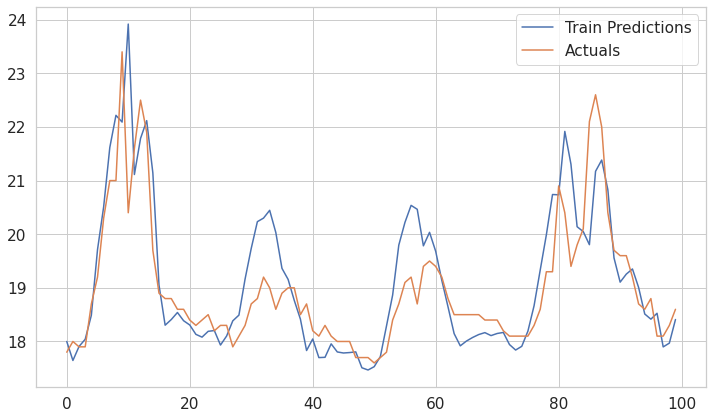




____________________________________________________________________________________________________
                                   Conv1d Model - VALIDATION DATA                                   


MAPE: 3.35%


      Val Predictions  Actuals
0           20.349962     19.6
1           21.020792     22.2
2           23.213163     24.2
3           24.815472     24.8
4           25.228403     23.4
...               ...      ...
8761        23.470179     24.0
8762        24.873692     22.8
8763        23.822050     21.6
8764        22.607658     24.6
8765        24.776728     24.5

[8766 rows x 2 columns]


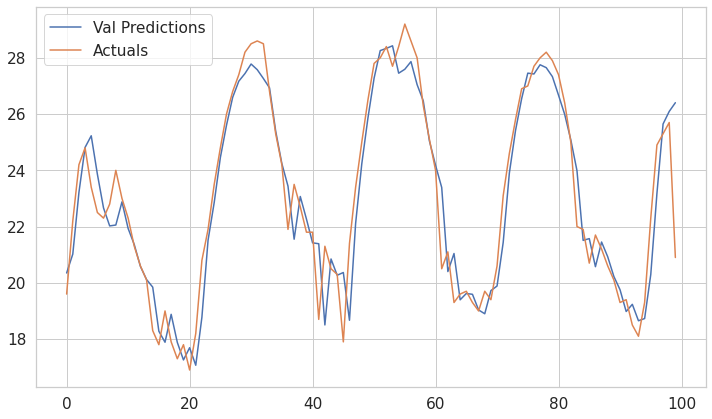




____________________________________________________________________________________________________
                                      Conv1d Model - TEST DATA                                      


MAPE: 3.28%


      Test Predictions  Actuals
0            24.298855     20.0
1            19.939224     22.3
2            21.786243     23.9
3            22.911932     23.9
4            22.799984     21.7
...                ...      ...
8761         27.395563     28.1
8762         26.985283     23.6
8763         22.793562     23.6
8764         22.856770     22.3
8765         21.755892     21.3

[8766 rows x 2 columns]


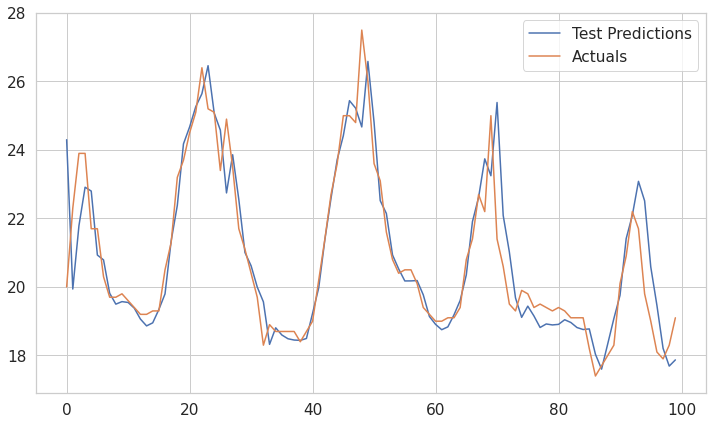

In [ ]:
show_model(model_conv1d_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='Conv1d')

# Summary of Results

,Train,Validation,Test
LSTM_cyclic,3.05,3.20,3.20
GRU_cyclic,3.05,3.23,3.20
conv1d_cyclic,3.12,3.29,3.26
LSTM,3.56,3.73,3.75
GRU,3.57,3.75,3.77
conv1d,3.84,3.96,3.98


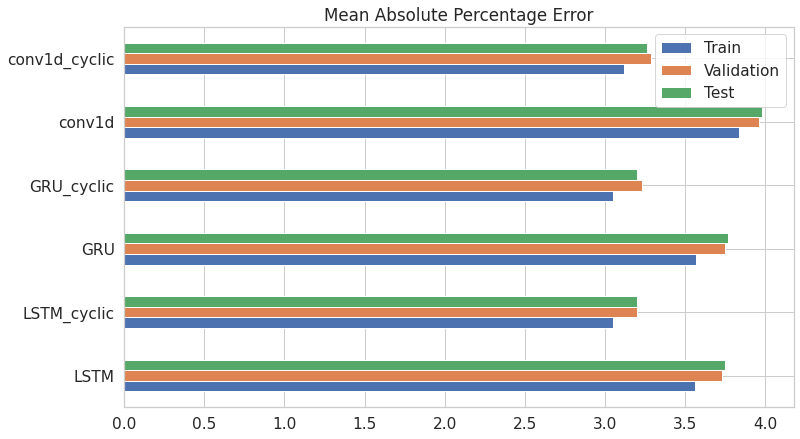

In [ ]:
def get_mape_from_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test):
  # Loading Model
  model = load_model(model_name + '/')

  # Getting MAPE for train set
  train_predictions = model.predict(X_train).flatten()
  train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
  mape_train = round(mean_absolute_percentage_error(y_train,train_predictions)*100,2)

  # Getting MAPE for validation set
  val_predictions = model.predict(X_val).flatten()
  val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
  mape_val = round(mean_absolute_percentage_error(y_val,val_predictions)*100,2)

  # Getting MAPE for test set
  test_predictions = model.predict(X_test).flatten()
  test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
  mape_test = round(mean_absolute_percentage_error(y_test,test_predictions)*100,2)

  return [mape_train, mape_val, mape_test]

models_list = [
               'model_LSTM',
               'model_LSTM_cyclic',
               'model_GRU',
               'model_GRU_cyclic',
               'model_conv1d',
               'model_conv1d_cyclic'
                ]

all_scores = {}
for model_name in models_list:
    if 'cyclic' in model_name:
        mape_list = get_mape_from_model(model_name, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test)
    else:
        mape_list = get_mape_from_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test)

    all_scores[model_name.replace('model_','')] = mape_list

all_scores = pd.DataFrame(all_scores)
all_scores.index = ['Train','Validation','Test']

all_scores_t = all_scores.transpose()

all_scores_t.plot.barh(title = 'Mean Absolute Percentage Error');
all_scores_t.sort_values('Test')